In [1]:
import time
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_with_depth

# import utils.contrastive_decoder_utils
from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import os
import yaml

with open("./arguments/hyper_param.yaml", "r") as f:
        hyper_param = yaml.safe_load(f)

SCENE_NAME = hyper_param["SCENE_NAME"]

FEATURE_DIM = hyper_param["gaussian"]["feature_dim"]

MODEL_PATH = f'/root/autodl-tmp/3dgs_output/{SCENE_NAME}'

FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')
FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

In [3]:
# scale_gate = torch.nn.Sequential(
#     torch.nn.Linear(1, 32, bias=True),
#     torch.nn.Sigmoid()
# )

# scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
# scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = False

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")


Looking for config file in /root/autodl-tmp/3dgs_output/replica_room/office2/cfg_args
Config file found: /root/autodl-tmp/3dgs_output/replica_room/office2/cfg_args
Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 200/200
Loading Training Cameras
Loading Test Cameras
There are 200 views in the dataset.


In [4]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
for cam in scene.getTrainCameras():
    # print(cam.original_masks.shape)
    all_scales.append(cam.mask_scales)

all_scales = torch.cat(all_scales)

# print(all_scales.shape)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')

9.450605 ?


# Cluster in 3D

In [6]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

# sampled_point_features = scale_conditioned_point_features
sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

features_np = normed_sampled_point_features.detach().cpu().numpy()

features_np = features_np[~np.isnan(features_np).any(axis=1)]
features_np = features_np[~np.isinf(features_np).any(axis=1)]

import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(features_np)
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34]


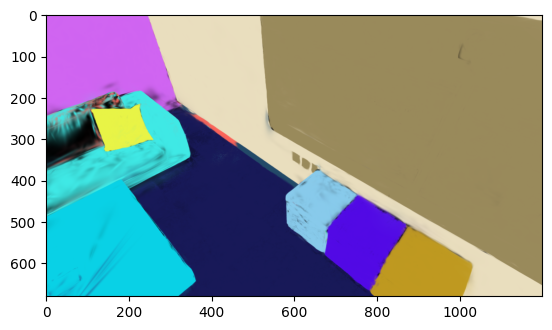

In [7]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

label_to_color = np.random.rand(1000, 3)
point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.5] = (0,0,0)

try:
    scene_gaussians.roll_back()
except:
    pass

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

rendered_seg_map = render(cameras[100], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

In [28]:

if SCENE_NAME == 'replica_room/room0':
    ### REPLICA_ROOM ROOM0
    ref_img_camera_ids = [187, 62, 125, 144, 21, 34]
    query_indices = [
        [[400, 850], [300, 850]], 
        [[500, 400]], 
        [[350, 520], [430, 520], [500, 520]], 
        [[350, 520], [430, 520], [500, 520], [530, 520]], 
        [[450, 500]], 
        [[500, 550]]
        ]
elif SCENE_NAME == 'replica_room/office2':
    ### REPLICA_ROOM OFFICE2
    ref_img_camera_ids = [0, 0, 0, 0, 81, 81, 81]
    query_indices = [
        [[400, 500]], 
        [[400, 200]], 
        [[350, 670]], 
        [[300, 450]], 
        [[150, 300]], 
        [[200, 450]],
        [[300, 550]]
        ]
elif SCENE_NAME == 'replica_room/room2':
    ### REPLICA_ROOM ROOM2
    ref_img_camera_ids = [70, 110, 110, 110, 178, 182, 182, 182]
    query_indices = [
        [[500, 550]], 
        [[400, 450]], 
        [[350, 500]], 
        [[300, 500]], 
        [[500, 250]], 
        [[350, 500]],
        [[300, 600]],
        [[300, 800]]
        ]
elif SCENE_NAME == 'houses':
    ### HOUSES
    ref_img_camera_ids = [0, 0, 46, 46, 46, 117, 117, 117, 138, 138]
    query_indices = [
        [[300, 700]], 
        [[300, 350]], 
        [[250, 500]], 
        [[250, 700]], 
        [[250, 900]], 
        [[300, 400]],
        [[400, 500]],
        [[400, 700]],
        [[250, 450]],
        [[250, 700]],
        ]


SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!


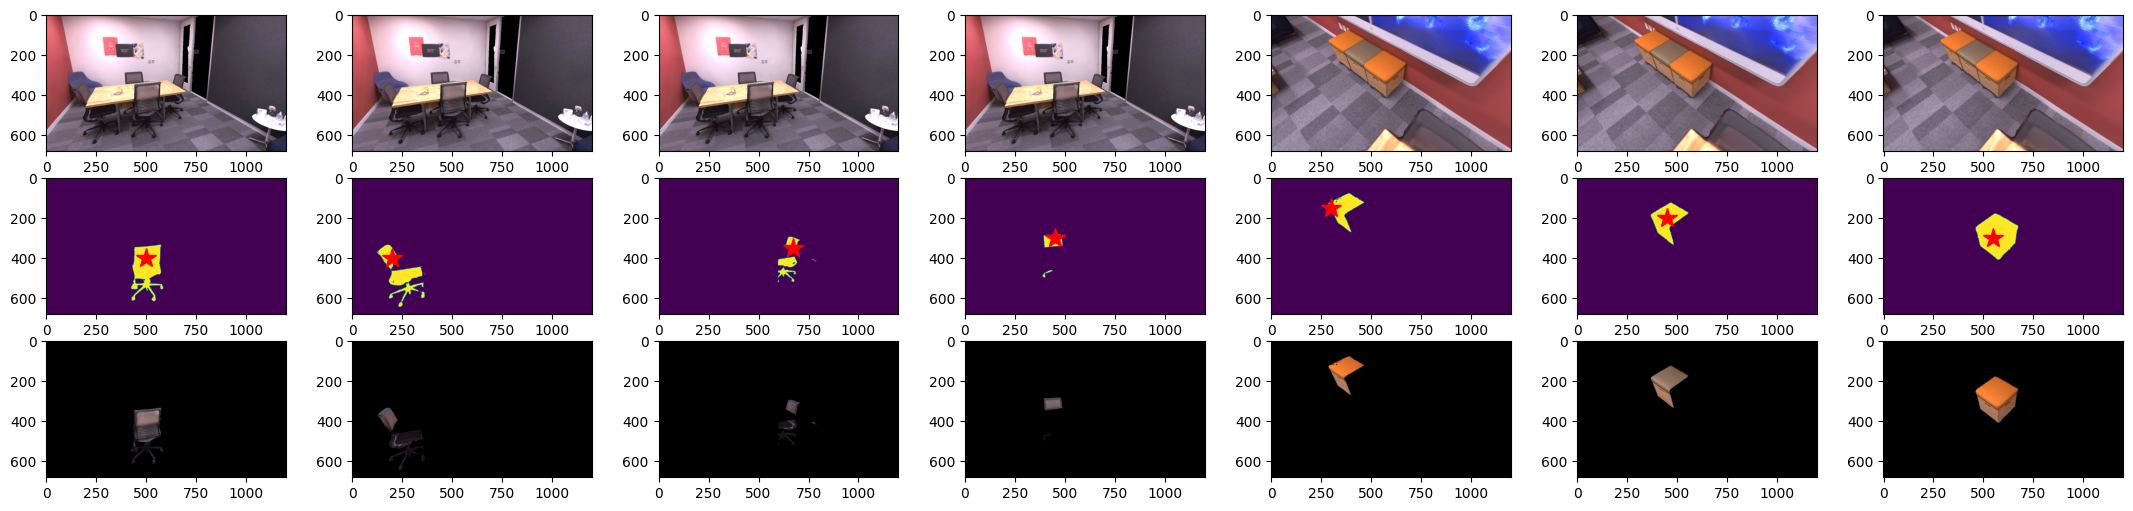

In [29]:
from copy import deepcopy
from torchvision.utils import save_image

seg_inst_path = f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst"
os.makedirs(seg_inst_path, exist_ok=True)

threshold = hyper_param["gaussian"]["similarity_threshold"]

# plt.figure(figsize=(20, 5))
fig, axs = plt.subplots(3, len(ref_img_camera_ids), figsize=(27, 6))

rendered_features = []
all_similarities = []
all_query_features = []

try:
    scene_gaussians.roll_back()
except:
    pass

for idx, ref_img_camera_id in enumerate(ref_img_camera_ids):
    view = deepcopy(cameras[ref_img_camera_id])

    view.feature_height, view.feature_width = view.image_height, view.image_width
    img = view.original_image * 255
    img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

    bg_color = [0 for i in range(FEATURE_DIM)]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]
    rendered_features.append(rendered_feature)

    feature_with_scale = rendered_feature
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])
    normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
    for id, query_index in enumerate(query_indices[idx]):
        query_index = [
            int(query_index[0] / view.image_height * view.feature_height),
            int(query_index[1] / view.image_width * view.feature_width)
            ]
        q_feature = normed_features[query_index[0], query_index[1]].reshape(-1, 1)
        if id == 0:
            query_features = q_feature
        else:
            query_features = torch.cat([query_features, q_feature], dim=-1)
    # print(query_features.shape)
    similarity = normed_features @ query_features # (H, W, k)
    similarity = torch.max(similarity, dim=-1).values
    # use similarity as mask
    similarity[similarity < threshold] = 0
    similarity[similarity != 0] = 1
    masked_image = view.original_image * similarity.unsqueeze(0)
    # print(view.original_image.shape)
    torch.save(similarity, f"{seg_inst_path}/{idx}.pt")
    
    point_features = feature_gaussians.get_point_features
    scale_conditioned_point_features = point_features
    normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)
    similarities = normed_scale_conditioned_point_features @ query_features # (N, k)
    similarities = torch.max(similarities, dim=-1).values
    similarities[similarities < threshold] = 0
    similarities[similarities != 0] = 1

    all_similarities.append(similarities)
    all_query_features.append(query_features)

    axs[0, idx].imshow(img)
    axs[0, idx].plot()
    axs[1, idx].imshow(similarity.detach().cpu().numpy())
    axs[1, idx].plot()
    axs[1, idx].plot(query_index[1], query_index[0], marker='*', color='red', markersize=15)  # 五角星标记
    axs[2, idx].imshow(masked_image.permute([1,2,0]).detach().cpu().numpy())
    axs[2, idx].plot()

    print("SAVE OCCURRED!!!")
    save_image(masked_image, f"{seg_inst_path}/{idx}.png")

    s_g = deepcopy(scene_gaussians)
    s_g.segment(similarities > 0)
    radii = render(view, s_g, pipeline.extract(args), background)["radii"]
    s_g.segment(radii > 0)
    s_g.save_ply(f"{seg_inst_path}/{idx}.ply")


all_similarities = torch.stack(all_similarities, dim=0)
all_similarities = torch.any(all_similarities.bool(), dim=0).int()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAVE OCCURRED!!!


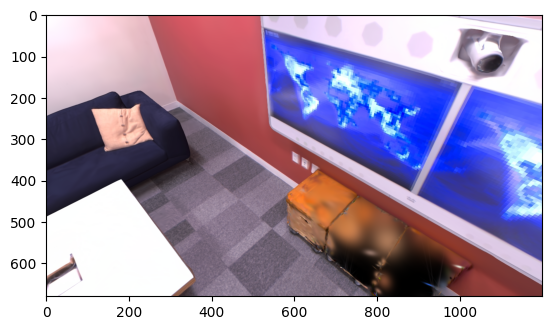

In [30]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(all_similarities == 0)

bg_image = render(cameras[100], scene_gaussians, pipeline.extract(args), background)['render']
plt.plot()
plt.imshow(bg_image.permute([1,2,0]).detach().cpu().numpy())

print("SAVE OCCURRED!!!")
scene_gaussians.save_ply(f'/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/bg.ply')


In [31]:
query_features = torch.cat(all_query_features, dim=-1)
for i in range(len(cameras)):
    view = deepcopy(cameras[i])
    view.feature_height, view.feature_width = view.image_height, view.image_width
    
    rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type=None)['render']
    rendered_feature = rendered_feature.permute([1, 2, 0])
    normed_features = torch.nn.functional.normalize(rendered_feature, dim = -1, p = 2)
    similarity = normed_features @ query_features # (H, W, all_k)
    similarity = torch.max(similarity, dim=-1).values

    similarity[similarity < threshold] = 0
    similarity[similarity != 0] = 1
    print("SAVE OCCURRED!!!")
    os.makedirs(f"/root/autodl-tmp/data/{SCENE_NAME}/instance_masks", exist_ok=True)
    torch.save(similarity, f"/root/autodl-tmp/data/{SCENE_NAME}/instance_masks/{view.image_name}.pt")

print("Done!")


SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!!!
SAVE OCCURRED!

torch.Size([680, 1200])


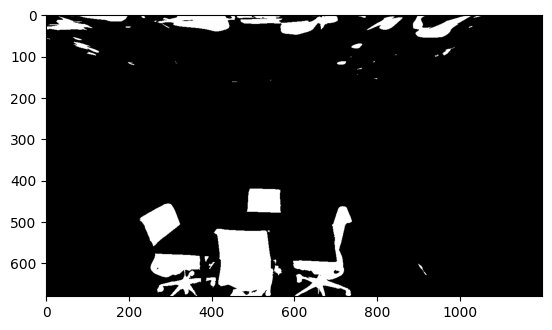

In [32]:

mask = torch.load(f"/root/autodl-tmp/data/{SCENE_NAME}/instance_masks/frame000240.pt")
print(mask.shape)
plt.imshow(mask.detach().cpu(), cmap='gray')

... loading model from /root/autodl-tmp/checkpoints/mast3r/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 2 images
 - adding /root/autodl-tmp/data/replica_room/office2/seg_inst/10.png with resolution 1200x680 --> 512x288
 - adding /root/autodl-tmp/data/replica_room/office2/seg_inst/8.png with resolution 1200x680 --> 512x288
 (Found 2 images)


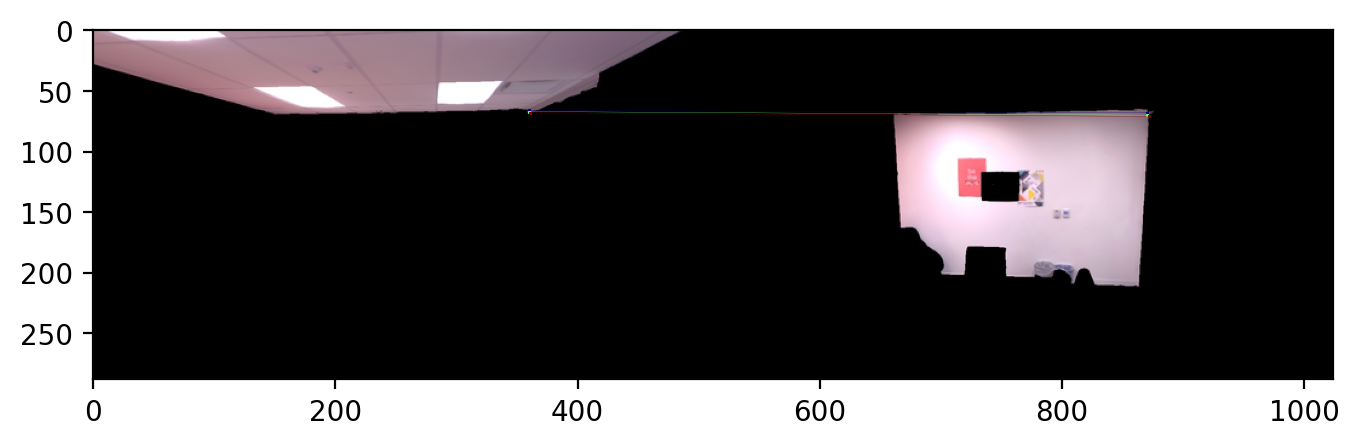

SAVE OCCURRED!!!
(3, 2) (3, 2)


In [ ]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs
import numpy as np

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

def filter_points_by_mask(points, mask, target_H, target_W):
    """
    points: (N, 2) numpy array, (x, y)
    mask: (H, W) numpy bool array
    target_H, target_W: int
    return: filtered_points (M, 2)
    """
    mask_uint8 = mask.astype(np.uint8) * 255
    resized_mask = cv2.resize(mask_uint8, (target_W.item(), target_H.item()), interpolation=cv2.INTER_NEAREST)
    resized_mask = resized_mask > 0  # 转回布尔掩码

    x = points[:, 0].astype(np.int64)
    y = points[:, 1].astype(np.int64)

    keep = resized_mask[y, x]  # 注意顺序：先 y 后 x
    return keep

# OBJECT_ID = [10, 8]

if __name__ == '__main__':
    device = 'cuda'
    schedule = 'cosine'
    # lr = 0.01
    # niter = 300

    model_name = "/root/autodl-tmp/checkpoints/mast3r/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    images = load_images([f'/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{OBJECT_ID[0]}.png', f'/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{OBJECT_ID[1]}.png'], size=512)
    # images = load_images(['dust3r/croco/assets/Chateau1.png', 'dust3r/croco/assets/Chateau2.png'], size=512)
    output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

    # print(output)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']

    desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

    # find 2D-2D matches between the two images
    matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                   device=device, dist='dot', block_size=2**13)

    # ignore small border around the edge
    H0, W0 = view1['true_shape'][0]
    valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
        matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

    H1, W1 = view2['true_shape'][0]
    valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
        matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

    valid_matches = valid_matches_im0 & valid_matches_im1
    matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

    # print(H0, W0, H1, W1)
    ## add mask
    mask_0 = torch.load(f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{OBJECT_ID[0]}.pt").detach().cpu().numpy()
    keep_0 = filter_points_by_mask(matches_im0, mask_0, H0, W0)
    mask_1 = torch.load(f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{OBJECT_ID[1]}.pt").detach().cpu().numpy()
    keep_1 = filter_points_by_mask(matches_im1, mask_1, H1, W1)
    keep = keep_0 & keep_1
    matches_im0, matches_im1 = matches_im0[keep], matches_im1[keep]

    # visualize a few matches
    import numpy as np
    import torch
    import torchvision.transforms.functional
    from matplotlib import pyplot as pl

    n_viz = matches_im0.shape[0]
    num_matches = matches_im0.shape[0]
    match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
    viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

    image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
    image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

    viz_imgs = []
    for i, view in enumerate([view1, view2]):
        rgb_tensor = view['img'] * image_std + image_mean
        viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

    H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
    img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img = np.concatenate((img0, img1), axis=1)
    pl.figure(figsize=(8, 6), dpi=200)
    pl.imshow(img)
    cmap = pl.get_cmap('jet')
    for i in range(n_viz):
        (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
        pl.plot([x0, x1 + W0], [y0, y1], linestyle='-', linewidth=0.1, marker='+', markersize=1, color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
    pl.show(block=True)

    matches_im0 = matches_im0.astype(np.float32)
    matches_im1 = matches_im1.astype(np.float32)
    matches_im0[:, 0] /= W0
    matches_im0[:, 1] /= H0
    matches_im1[:, 0] /= W1
    matches_im1[:, 1] /= H1

    pair_path = f'/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{OBJECT_ID[0]}<->{OBJECT_ID[1]}'
    os.makedirs(pair_path, exist_ok=True)
    print("SAVE OCCURRED!!!")
    np.save(f'{pair_path}/{OBJECT_ID[0]}.npy', matches_im0)
    np.save(f'{pair_path}/{OBJECT_ID[1]}.npy', matches_im1)

    print(matches_im0.shape, matches_im1.shape)

In [14]:
def geotrf(Trf, pts, ncol=None, norm=False):
    """ Apply a geometric transformation to a list of 3-D points.

    H: 3x3 or 4x4 projection matrix (typically a Homography)
    p: numpy/torch/tuple of coordinates. Shape must be (...,2) or (...,3)

    ncol: int. number of columns of the result (2 or 3)
    norm: float. if != 0, the resut is projected on the z=norm plane.

    Returns an array of projected 2d points.
    """
    assert Trf.ndim >= 2
    if isinstance(Trf, np.ndarray):
        pts = np.asarray(pts)
    elif isinstance(Trf, torch.Tensor):
        pts = torch.as_tensor(pts, dtype=Trf.dtype)

    # adapt shape if necessary
    output_reshape = pts.shape[:-1]
    ncol = ncol or pts.shape[-1]

    # optimized code
    if (isinstance(Trf, torch.Tensor) and isinstance(pts, torch.Tensor) and
            Trf.ndim == 3 and pts.ndim == 4):
        d = pts.shape[3]
        if Trf.shape[-1] == d:
            pts = torch.einsum("bij, bhwj -> bhwi", Trf, pts)
        elif Trf.shape[-1] == d + 1:
            pts = torch.einsum("bij, bhwj -> bhwi", Trf[:, :d, :d], pts) + Trf[:, None, None, :d, d]
        else:
            raise ValueError(f'bad shape, not ending with 3 or 4, for {pts.shape=}')
    else:
        if Trf.ndim >= 3:
            n = Trf.ndim - 2
            assert Trf.shape[:n] == pts.shape[:n], 'batch size does not match'
            Trf = Trf.reshape(-1, Trf.shape[-2], Trf.shape[-1])

            if pts.ndim > Trf.ndim:
                # Trf == (B,d,d) & pts == (B,H,W,d) --> (B, H*W, d)
                pts = pts.reshape(Trf.shape[0], -1, pts.shape[-1])
            elif pts.ndim == 2:
                # Trf == (B,d,d) & pts == (B,d) --> (B, 1, d)
                pts = pts[:, None, :]

        if pts.shape[-1] + 1 == Trf.shape[-1]:
            Trf = Trf.swapaxes(-1, -2)  # transpose Trf
            pts = pts @ Trf[..., :-1, :] + Trf[..., -1:, :]
        elif pts.shape[-1] == Trf.shape[-1]:
            Trf = Trf.swapaxes(-1, -2)  # transpose Trf
            pts = pts @ Trf
        else:
            pts = Trf @ pts.T
            if pts.ndim >= 2:
                pts = pts.swapaxes(-1, -2)

    if norm:
        pts = pts / pts[..., -1:]
        if norm != 1:
            pts *= norm

    res = pts[..., :ncol].reshape(*output_reshape, ncol)
    return res

def inv(mat):
    """ Invert a torch or numpy matrix
    """
    if isinstance(mat, torch.Tensor):
        return torch.linalg.inv(mat)
    if isinstance(mat, np.ndarray):
        return np.linalg.inv(mat)
    raise ValueError(f'bad matrix type = {type(mat)}')


def mask110(device, dtype):
    return torch.tensor((1, 1, 0), device=device, dtype=dtype)


def proj3d(inv_K, pixels, z):
    inv_K = torch.tensor(inv_K, dtype=torch.float32, device="cuda")
    pixels = torch.tensor(pixels, dtype=torch.float32, device="cuda")
    z = torch.tensor(z, dtype=torch.float32, device="cuda")
    if pixels.shape[-1] == 2:
        pixels = torch.cat((pixels, torch.ones_like(pixels[..., :1])), dim=-1)
    return z.unsqueeze(-1) * (pixels * inv_K.diag() + inv_K[:, 2] * mask110(z.device, z.dtype))

def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    # pcd_down = pcd.voxel_down_sample(voxel_size)
    pcd_down = pcd

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    print(":: Apply fast global registration with distance threshold %.3f" \
            % distance_threshold)
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

In [15]:
def mast3r_to_pts3d(mast3r_p, view, depth):
    K = view.intrinsics
    inv_K = inv(K)
    pixels = np.zeros((mast3r_p.shape[0], mast3r_p.shape[1])).astype(np.int16)
    pixels[:, 0] = (mast3r_p[:, 0] * view.image_width).astype(np.int16)
    pixels[:, 1] = (mast3r_p[:, 1] * view.image_height).astype(np.int16)

    z = []
    for p in pixels:
        z.append(depth[p[1], p[0]])
    z = np.array(z)

    Rt = np.zeros((4, 4))
    Rt[:3, :3] = view.R.transpose()
    Rt[:3, 3] = view.T
    Rt[3, 3] = 1.0
    cam2w = np.linalg.inv(Rt)
    cam2w = torch.tensor(cam2w, dtype=torch.float32, device="cuda")

    pts3d = proj3d(inv_K, pixels, z)
    pts3d = geotrf(cam2w, pts3d)
    pts3d = pts3d.detach().cpu().numpy().astype(np.float32)

    return pts3d

def umeyama(X, Y):
    """
    X, Y: [N, 3] numpy arrays, 一一对应点集
    返回: 4x4 齐次变换矩阵 T，使得 Y ≈ T @ X_homo.T
    """
    assert X.shape == Y.shape
    N = X.shape[0]

    mu_X = X.mean(axis=0)
    mu_Y = Y.mean(axis=0)

    X0 = X - mu_X
    Y0 = Y - mu_Y

    var_X = (X0 ** 2).sum() / N

    K = (Y0.T @ X0) / N
    U, D, Vt = np.linalg.svd(K)

    R = U @ Vt
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = U @ Vt

    s = np.sum(D) / var_X
    t = mu_Y - s * R @ mu_X

    # 构建 4x4 齐次变换矩阵
    T = np.eye(4)
    T[:3, :3] = s * R
    T[:3, 3] = t
    return T

def umeyama_rigid(X, Y):
    """
    估计刚性变换（不含缩放）
    X, Y: [N, 3] numpy arrays, 一一对应点集
    返回: 4x4 齐次变换矩阵 T，使得 Y ≈ T @ X_homo.T
    """
    assert X.shape == Y.shape
    N = X.shape[0]

    mu_X = X.mean(axis=0)
    mu_Y = Y.mean(axis=0)

    X0 = X - mu_X
    Y0 = Y - mu_Y

    H = X0.T @ Y0
    U, _, Vt = np.linalg.svd(H)

    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = mu_Y - R @ mu_X

    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

---------------Processing template 0
-----------Processing instance 1
:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.500.
:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.500.


/tmp/ipykernel_2199/2101317928.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inv_K = torch.tensor(inv_K, dtype=torch.float32, device="cuda")


:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.100,
   we use a liberal distance threshold 0.150.
粗力度初始化： [[-0.18019351  0.52241713 -0.83343304 -1.98361445]
 [-0.48477925  0.6900848   0.53737514  1.22144581]
 [ 0.85587346  0.50086256  0.12890818 -1.91570189]
 [ 0.          0.          0.          1.        ]]
Initial alignment
RegistrationResult with fitness=9.013162e-01, inlier_rmse=5.888997e-02, and correspondence_set size of 12942
Access transformation to get result.
Apply point-to-point ICP
ICP transform is:
[[-3.74591382e-01  5.31163729e-01 -7.59964730e-01 -1.94825086e+00]
 [-4.38626240e-01  6.20607501e-01  6.49964116e-01  1.49851477e+00]
 [ 8.16877174e-01  5.76811428e-01  5.08128125e-04 -2.20553271e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
RegistrationResult with fitness=2.510621e-01, inlier_rmse=1.158964e-01, and correspondence_set size of 3605
Access transformation to get result.
[[-0.09942571  0.6359

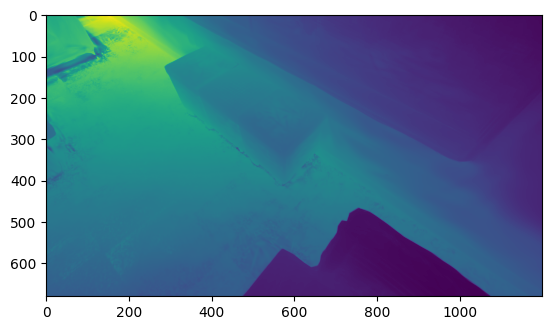

In [17]:
### 直接估计两个点云的变换
import open3d as o3d

template_ids = [0, 6]
inst_ids = [[1, 2, 3], [4, 5]]
# template_ids = [1]
# inst_ids = [[0, 2, 3, 4, 5, 6, 7]]

scene_graph = []

reg_voxel_size = hyper_param["registration"]["voxel_size"]
reg_threshold = hyper_param["registration"]["threshold"]

for t_id, template_id in enumerate(template_ids):
    print("---------------Processing template", template_id)
    temp_map = {}
    temp_map["template_id"] = template_id
    temp_map["instances"] = []
    # add the template itself
    inst_map = {}
    inst_map["instance_id"] = template_id
    inst_map["transform"] = np.eye(4).tolist()
    temp_map["instances"].append(inst_map)

    for inst_id in inst_ids[t_id]:
        print("-----------Processing instance", inst_id)
        try:
            scene_gaussians.roll_back()
        except:
            pass

        inst_map = {}
        inst_map["instance_id"] = inst_id

        ### 1. xxx
        template = np.load(f'/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{inst_id}<->{template_id}/{template_id}.npy')
        temp_view = cameras[ref_img_camera_ids[template_id]]
        depth = render_with_depth(temp_view, scene_gaussians, pipeline.extract(args), background)['depth'].detach().cpu().numpy().squeeze()
        temp_pts3d = mast3r_to_pts3d(template, temp_view, depth)

        inst = np.load(f'/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{inst_id}<->{template_id}/{inst_id}.npy')
        inst_view = cameras[ref_img_camera_ids[inst_id]]
        depth = render_with_depth(inst_view, scene_gaussians, pipeline.extract(args), background)['depth'].detach().cpu().numpy().squeeze()
        inst_pts3d = mast3r_to_pts3d(inst, inst_view, depth)

        plt.plot()
        plt.imshow(depth)

        umeyama_transform = umeyama_rigid(inst_pts3d, temp_pts3d)

        pcd = o3d.io.read_point_cloud(f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{inst_id}.ply")
        pcd_points = np.asarray(pcd.points)
        pcd_points_homo = np.hstack((pcd_points, np.ones((pcd_points.shape[0], 1)))).transpose()
        
        trans_pcd_points_homo = umeyama_transform @ pcd_points_homo

        trans_pcd_points = trans_pcd_points_homo.transpose()[:, :3]
        # print(trans_pcd_points)
        trans_pcd = o3d.geometry.PointCloud()
        trans_pcd.points = o3d.utility.Vector3dVector(trans_pcd_points)
        o3d.io.write_point_cloud(f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{inst_id}_trans_pcd.ply", trans_pcd)

        ### 3. finetune the transformation using ICP
        target = o3d.io.read_point_cloud(f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{template_id}.ply")
        source = trans_pcd

        source_down, source_fpfh = preprocess_point_cloud(source, reg_voxel_size)
        target_down, target_fpfh = preprocess_point_cloud(target, reg_voxel_size)
        result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            reg_voxel_size)
        # result_fast = execute_fast_global_registration(source_down, target_down,
        #                                        source_fpfh, target_fpfh,
        #                                        reg_voxel_size)
        print("粗力度初始化：", result_ransac.transformation) 

        trans_init = result_ransac.transformation
        print("Initial alignment")
        evaluation = o3d.pipelines.registration.evaluate_registration(
            source, target, reg_threshold, trans_init)
        print(evaluation)

        print("Apply point-to-point ICP")
        reg_p2p = o3d.pipelines.registration.registration_icp(
            source, target, reg_threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=3000))
        # print(reg_p2p)
        print("ICP transform is:")
        print(reg_p2p.transformation)
        evaluation = o3d.pipelines.registration.evaluate_registration(
            source.transform(reg_p2p.transformation), target, reg_threshold, trans_init)
        print(evaluation)
        source.transform(reg_p2p.transformation)

        final_transform = reg_p2p.transformation @ umeyama_transform
        print(final_transform)

        inst_map["transform"] = final_transform.tolist()
        temp_map["instances"].append(inst_map)

    scene_graph.append(temp_map)

print("Scene graph:", scene_graph)

# save the scene graph to a file
import json
scene_graph_path = f'/root/autodl-tmp/data/{SCENE_NAME}/scene_graph.json'
with open(scene_graph_path, 'w') as f:
    json.dump(scene_graph, f, indent=4)
print(f"Scene graph saved to {scene_graph_path}")

---------------Processing template 0
-----------Processing instance 1
(61, 2) (61, 2)
inst cam pose:
 [[-0.93480932  0.08400978 -0.34507086  1.2223753 ]
 [-0.24174855  0.56125781  0.79154741 -1.71838721]
 [ 0.26017144  0.82336628 -0.50435979  2.96468684]
 [ 0.          0.          0.          1.        ]]
(61, 3) (61, 2)
Est. another cam pose:
 [[-0.35551205 -0.52650456  0.77227206 -2.1259427 ]
 [ 0.6645137   0.43866814  0.60497256  0.81130714]
 [-0.65729196  0.7282604   0.19391769 -2.9797889 ]
 [ 0.          0.          0.          1.        ]]
Template cam pose:
 [[-0.93480932  0.08400978 -0.34507086  1.2223753 ]
 [-0.24174855  0.56125781  0.79154741 -1.71838721]
 [ 0.26017144  0.82336628 -0.50435979  2.96468684]
 [ 0.          0.          0.          1.        ]]
:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.500.


/tmp/ipykernel_56062/2101317928.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inv_K = torch.tensor(inv_K, dtype=torch.float32, device="cuda")


:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.500.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.100,
   we use a liberal distance threshold 0.150.
粗力度初始化： [[ 0.96846096  0.16255824  0.18883373 -0.41324642]
 [-0.17403602  0.98367512  0.04576825 -0.37463474]
 [-0.17831103 -0.07718863  0.98094194  0.66957889]
 [ 0.          0.          0.          1.        ]]
Initial alignment
RegistrationResult with fitness=8.472735e-01, inlier_rmse=8.075510e-02, and correspondence_set size of 12166
Access transformation to get result.
Apply point-to-point ICP
ICP transform is:
[[ 0.96368804  0.23861553  0.11986654 -0.81435673]
 [-0.25359253  0.9584113   0.13091448 -0.27338458]
 [-0.08364322 -0.15655798  0.98412063  0.9965986 ]
 [ 0.          0.          0.          1.        ]]
RegistrationResult with fitness=4.881956e-02, inlier_rmse=1.693995e-01, and correspondence_set s

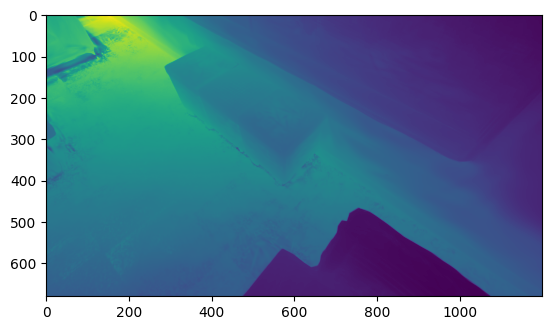

In [ ]:
### 估计一个点云，使用PnP估计相机位姿
import open3d as o3d
template_ids = [0, 6]
inst_ids = [[1, 2, 3], [4, 5]]

scene_graph = []

for t_id, template_id in enumerate(template_ids):
    print("---------------Processing template", template_id)
    temp_map = {}
    temp_map["template_id"] = template_id
    temp_map["instances"] = []
    # add the template itself
    inst_map = {}
    inst_map["instance_id"] = template_id
    inst_map["transform"] = np.eye(4).tolist()
    temp_map["instances"].append(inst_map)
    for inst_id in inst_ids[t_id]:
        print("-----------Processing instance", inst_id)
        try:
            scene_gaussians.roll_back()
        except:
            pass

        inst_map = {}
        inst_map["instance_id"] = inst_id
        ### 1. estimate the camera pose around each instance that looks similar as template.
        view = cameras[ref_img_camera_ids[inst_id]]
        rendered_pkg = render_with_depth(view, scene_gaussians, pipeline.extract(args), background)
        depth = rendered_pkg['depth']
        depth = depth.detach().cpu().numpy().squeeze()

        plt.plot()
        plt.imshow(depth)

        template = np.load(f'/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{inst_id}<->{template_id}/{template_id}.npy')
        inst = np.load(f'/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{inst_id}<->{template_id}/{inst_id}.npy')

        print(template.shape, inst.shape)

        # print(view.image_width, view.image_height)

        inst_pts3d = mast3r_to_pts3d(inst, view, depth)

        target_pixels = np.zeros((template.shape[0], template.shape[1])).astype(np.int16)
        target_pixels[:, 0] = (template[:, 0] * view.image_width).astype(np.int16)
        target_pixels[:, 1] = (template[:, 1] * view.image_height).astype(np.int16)

        # K = view.intrinsics
        # inv_K = inv(K)
        # pixels = np.zeros((inst.shape[0], inst.shape[1])).astype(np.int16)
        # pixels[:, 0] = (inst[:, 0] * view.image_width).astype(np.int16)
        # pixels[:, 1] = (inst[:, 1] * view.image_height).astype(np.int16)

        # target_pixels = np.zeros((template.shape[0], template.shape[1])).astype(np.int16)
        # target_pixels[:, 0] = (template[:, 0] * view.image_width).astype(np.int16)
        # target_pixels[:, 1] = (template[:, 1] * view.image_height).astype(np.int16)

        # z = []
        # for p in pixels:
        #     z.append(depth[p[1], p[0]])
        # z = np.array(z)

        # Rt = np.zeros((4, 4))
        # Rt[:3, :3] = view.R.transpose()
        # Rt[:3, 3] = view.T
        # Rt[3, 3] = 1.0
        # cam2w = np.linalg.inv(Rt)
        # print("inst cam pose:\n", cam2w)

        # cam2w = torch.tensor(cam2w, dtype=torch.float32, device="cuda")
        # pts3d = proj3d(inv_K, pixels, z)
        # pts3d = geotrf(cam2w, pts3d)
        # pts3d = pts3d.detach().cpu().numpy().astype(np.float32)
        target_pixels = target_pixels.astype(np.float32)

        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pts3d.reshape(-1, 3))
        o3d.io.write_point_cloud(f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{inst_id}_keypoints.ply", pcd)
        
        print(inst_pts3d.shape, target_pixels.shape)
        
        success, rvec, tvec, inliers = cv2.solvePnPRansac(
            objectPoints=inst_pts3d,
            imagePoints=target_pixels,
            cameraMatrix=view.intrinsics.detach().cpu().numpy(),
            distCoeffs=np.zeros(5),  # Assuming no lens distortion
            # iterationsCount=1000,
            # reprojectionError=2.0,
            # confidence=0.999,
            flags=cv2.SOLVEPNP_ITERATIVE
        )
        if success:
            # print("Rotation vector (rvec):\n", rvec)
            # print("Translation vector (tvec):\n", tvec)
            # print("Inliers:\n", inliers.shape)
            # 将 rvec 转换为旋转矩阵
            R_source, _ = cv2.Rodrigues(rvec)
            # print("Rotation matrix:\n", R_source)
        else:
            print("PnP estimation failed.")

        new_cam2w = np.eye(4)
        new_cam2w[:3, :3] = R_source
        new_cam2w[:3, 3] = tvec.flatten()
        new_w2cam = np.linalg.inv(new_cam2w)
        print("Est. another cam pose:\n", new_w2cam)

        ### 2. compute the transformation from instance to template
        temp_view = cameras[ref_img_camera_ids[template_id]]

        Rt = np.zeros((4, 4))
        Rt[:3, :3] = temp_view.R.transpose()
        Rt[:3, 3] = temp_view.T
        Rt[3, 3] = 1.0
        cam2w_2 = np.linalg.inv(Rt)
        print("Template cam pose:\n", cam2w_2)

        pcd = o3d.io.read_point_cloud(f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{inst_id}.ply")
        pcd_points = np.asarray(pcd.points)
        pcd_points_homo = np.hstack((pcd_points, np.ones((pcd_points.shape[0], 1)))).transpose()
        trans_pcd_points_homo = cam2w_2 @ np.linalg.inv(new_w2cam) @ pcd_points_homo

        trans_pcd_points = trans_pcd_points_homo.transpose()[:, :3]
        # print(trans_pcd_points)
        trans_pcd = o3d.geometry.PointCloud()
        trans_pcd.points = o3d.utility.Vector3dVector(trans_pcd_points)
        o3d.io.write_point_cloud(f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{inst_id}_trans_pcd.ply", trans_pcd)

        ### 3. finetune the transformation using ICP
        target = o3d.io.read_point_cloud(f"/root/autodl-tmp/data/{SCENE_NAME}/seg_inst/{template_id}.ply")
        source = trans_pcd

        voxel_size = 0.1
        source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
        target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
        result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
        # result_fast = execute_fast_global_registration(source_down, target_down,
        #                                        source_fpfh, target_fpfh,
        #                                        voxel_size)
        print("粗力度初始化：", result_ransac.transformation) 

        threshold = 0.2
        trans_init = result_ransac.transformation
        print("Initial alignment")
        evaluation = o3d.pipelines.registration.evaluate_registration(
            source, target, threshold, trans_init)
        print(evaluation)

        print("Apply point-to-point ICP")
        reg_p2p = o3d.pipelines.registration.registration_icp(
            source, target, threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=3000))
        # print(reg_p2p)
        print("ICP transform is:")
        print(reg_p2p.transformation)
        evaluation = o3d.pipelines.registration.evaluate_registration(
            source.transform(reg_p2p.transformation), target, threshold, trans_init)
        print(evaluation)
        source.transform(reg_p2p.transformation)


        final_transform = reg_p2p.transformation @ cam2w_2 @ np.linalg.inv(new_w2cam)
        print(final_transform)

        inst_map["transform"] = final_transform.tolist()
        temp_map["instances"].append(inst_map)

    scene_graph.append(temp_map)

print("Scene graph:", scene_graph)

# save the scene graph to a file
import json
scene_graph_path = f'/root/autodl-tmp/data/{SCENE_NAME}/scene_graph.json'
with open(scene_graph_path, 'w') as f:
    json.dump(scene_graph, f, indent=4)
print(f"Scene graph saved to {scene_graph_path}")